In [1]:
import pandas as pd
from tslearn.utils import load_time_series_txt

Read time series and labels of cpu.

In [2]:
new_ts = load_time_series_txt('../data/amazon/NEW_ts_1y.txt')
labels = pd.read_csv('../data/amazon/NEW_label_1y.txt', header=None, names=['label'])
labels.head()

,label
0,cpu Intel core i9-10940X
1,cpu Intel core i9-10920X
2,cpu Intel core i9-10900X
3,cpu Intel core i9-10900K
4,cpu Intel core i9-10900KF


Define a special transformer to normalize data.

In [3]:
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMinMax

class TimeSeriesScalerZeroMax(TimeSeriesScalerMinMax):
    def __init__(self, value_range=(0., 1)):
        super().__init__(value_range=value_range)

    def fit(self, X, y=None, **kwargs):
        return super().fit(X)

    def fit_transform(self, X, y=None, **kwargs):
         return self.fit(X).transform(X)

    def transform(self, X, y=None, **kwargs):
        value_range = self.value_range
        max_t = np.nanmax(X, axis=1)[:, np.newaxis]
        range_t = max_t
        range_t[range_t == 0.] = 1.
        X_ = X * (value_range[1] - value_range[0]) / range_t + value_range[0]
        X_[X == -1] = -1
        X_ = to_time_series_dataset(X_)
        return X_

Do transformation on the data set.

In [4]:
X = TimeSeriesScalerZeroMax().fit_transform(new_ts)

Use TimeSeriesKMeans with dtw to cluster our time series.

In [5]:
import time

t = time.time()
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=8, metric="dtw", random_state=501, max_iter=20, n_jobs=-1)
y_pred = km.fit_predict(X)
print(f'Finish training, time elapsed: {time.time() - t:.2f}s.')

Finish training, time elapsed: 115.84s.


Write functions to plot by clusters and show the labels in each cluster.

In [6]:
from matplotlib import pyplot as plt

def plot_cluster(km_model, X_pred, y_pred, figname, show_center=True):
    plt.figure(figsize=(10, 2 * km_model.n_clusters))
    for yi in range(km_model.n_clusters):
        plt.subplot(km_model.n_clusters // 2, 2, yi + 1)
        for xx in X_pred[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        if show_center:
            plt.plot(km_model.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(-0.2, 1.2)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
    plt.savefig(f'picture/{figname}.png', dpi=300, bbox_inches='tight')

def show_labels(km_model, y_pred, y_labels):
    label_by_cluster = [[] for _ in range(km_model.n_clusters)]
    for idx, label in enumerate(y_pred):
        label_by_cluster[label].append(y_labels.values[idx])
    for idx, ls in enumerate(label_by_cluster):
        print(f'Cluster {idx + 1}: ')
        def print_category(catagory):
            cata_labels = [l for l in ls if l.startswith(catagory)]
            if not cata_labels: return
            print(f'\t{len(cata_labels)} {catagory}: ', ', '.join(cata_labels))
        print_category('cpu')
        print_category('gpu')
        print_category('drive')

Test two functions.

Cluster 1: 
	2 cpu:  cpu Intel core i3-10300, cpu AMD ryzen 3 3100
	16 gpu:  gpu MSI NVIDIA Geforce RTX 2060 Super, gpu MSI NVIDIA Geforce RTX 2070, gpu MSI NVIDIA Geforce RTX 2070 Super, gpu MSI NVIDIA Geforce RTX 2080 Super, gpu MSI AMD Radeon RX 5600 XT, gpu EVGA NVIDIA Geforce GTX 1660 Ti, gpu EVGA NVIDIA Geforce RTX 2060, gpu Sapphire Technology AMD Radeon RX 5500 XT, gpu Sapphire Technology AMD Radeon RX 5500 XT, gpu Sapphire Technology AMD Radeon RX 5700 XT, gpu Sapphire Technology AMD Radeon RX 5700 XT, gpu Gigabyte NVIDIA Geforce RTX 2080 Super, gpu ZOTAC NVIDIA Geforce GTX 1660, gpu ZOTAC NVIDIA Geforce RTX 2060 Super, gpu ZOTAC NVIDIA Geforce RTX 2070 Super, gpu ZOTAC NVIDIA Geforce RTX 2080 Super
	1 drive:  drive Seagate skyhawk ai 35 12tb
Cluster 2: 
	5 cpu:  cpu Intel core i9-10900KF, cpu Intel core i9-9900K, cpu Intel core i7-10700KF, cpu Intel core i7-10700F, cpu Intel core i5-10600K
	20 drive:  drive Crucial p5 nvme 1tb, drive Crucial p5 nvme 2tb, drive Crucial p2 nvme

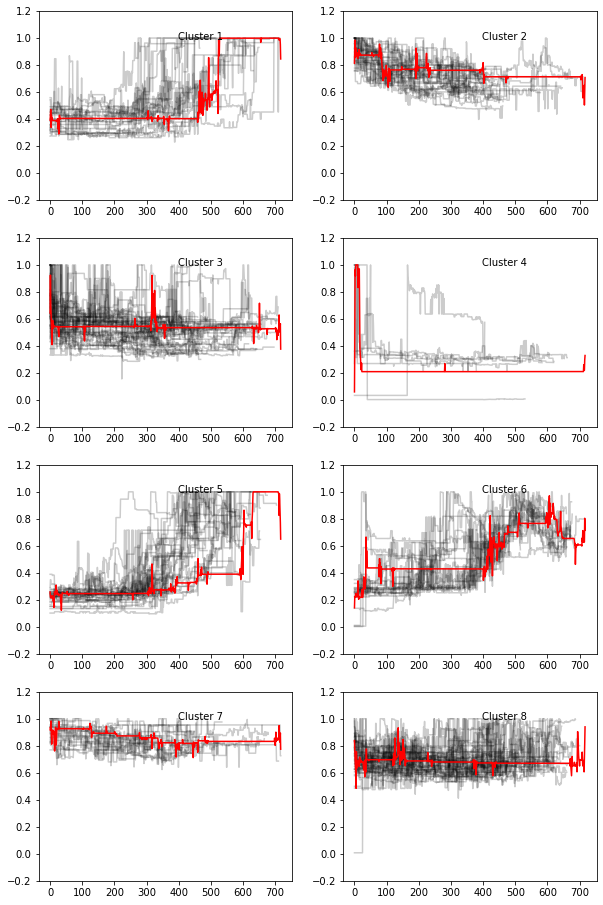

In [7]:
plot_cluster(km, X, y_pred, 'new_1y_dtw_8')
show_labels(km, y_pred, labels['label'])

The cluster 1, 5, 6 are pretty good! Both clusters mainly contain graphic cards and show the huge increment in prices.

Let's try another metric.

In [8]:
from numpy import VisibleDeprecationWarning
import warnings
t = time.time()
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning)
kms = TimeSeriesKMeans(n_clusters=6, metric='softdtw', random_state=501, max_iter=10, n_jobs=-1)
y_pred1 = kms.fit_predict(X)
print(f'Finish training, time elapsed: {time.time() - t:.2f}s.')

Finish training, time elapsed: 435.88s.


Cluster 1: 
	1 cpu:  cpu Intel core i9-9900KS
	26 gpu:  gpu MSI NVIDIA Geforce GTX 1650, gpu MSI NVIDIA Geforce GTX 1650, gpu MSI NVIDIA Geforce GTX 1660 Super, gpu MSI NVIDIA Geforce GTX 1660 Super, gpu MSI NVIDIA Geforce RTX 2060 Super, gpu MSI NVIDIA Geforce RTX 2070, gpu MSI NVIDIA Geforce RTX 2070 Super, gpu MSI NVIDIA Geforce RTX 2080 Super, gpu MSI AMD Radeon RX 5500 XT, gpu EVGA NVIDIA Geforce GTX 1650, gpu EVGA NVIDIA Geforce GTX 1650, gpu EVGA NVIDIA Geforce GTX 1660 Super, gpu ASUS NVIDIA Geforce GTX 1650 Super, gpu ASUS NVIDIA Geforce GTX 1660 Super, gpu ASUS NVIDIA Geforce GTX 1660 Super, gpu ASUS NVIDIA Geforce GTX 1660 Super, gpu XFX AMD Radeon RX 5700 XT, gpu Sapphire Technology AMD Radeon RX 5500 XT, gpu Sapphire Technology AMD Radeon RX 5700 XT, gpu Gigabyte NVIDIA Geforce GTX 1650, gpu Gigabyte NVIDIA Geforce RTX 2080 Super, gpu ZOTAC NVIDIA Geforce GTX 1660, gpu ZOTAC NVIDIA Geforce GTX 1660 Super, gpu ZOTAC NVIDIA Geforce RTX 2060, gpu ZOTAC NVIDIA Geforce RTX 2060

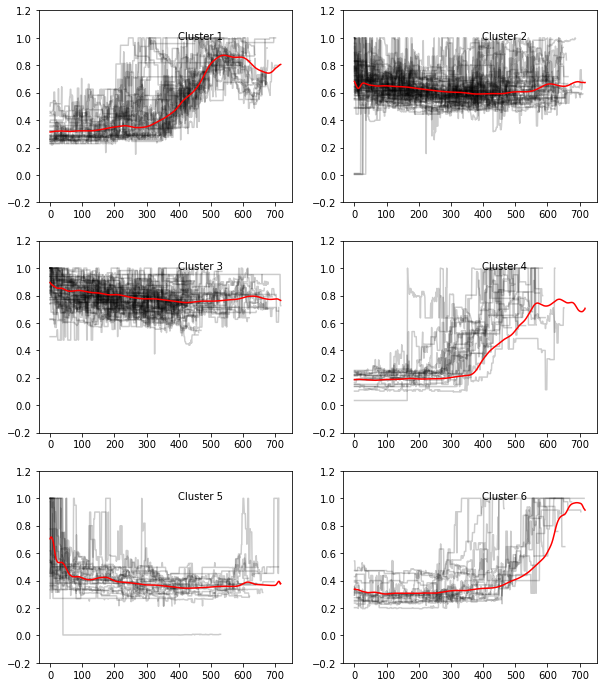

In [9]:
plot_cluster(kms, X, y_pred1, 'new_1y_softdtw_6')
show_labels(kms, y_pred1, labels['label'])

It takes 10 times longer to fit a softdtw model but the cluster centers are much better.
Let's try another data set.

In [10]:
new_ts1 = load_time_series_txt('../data/amazon/NEW_ts_6m.txt')
labels1 = pd.read_csv('../data/amazon/NEW_label_6m.txt', header=None, names=['label'])
X1 = TimeSeriesScalerZeroMax().fit_transform(new_ts1)

Cluster again and show the result.

In [11]:
t = time.time()
kms1 = TimeSeriesKMeans(n_clusters=6, metric='softdtw', random_state=501, max_iter=20, n_jobs=-1)
y_pred1 = kms1.fit_predict(X1)
print(f'Finish training, time elapsed: {time.time() - t:.2f}s.')

Finish training, time elapsed: 67.72s.


Cluster 1: 
	2 cpu:  cpu Intel core i9-10900K, cpu Intel core i5-10600KF
	3 gpu:  gpu ASUS NVIDIA Geforce RTX 3060, gpu Gigabyte NVIDIA Geforce RTX 3060, gpu ZOTAC NVIDIA Geforce RTX 3060
	1 drive:  drive WD_BLACK sn850 nvme 1tb
Cluster 2: 
	3 cpu:  cpu AMD ryzen 9 5950X, cpu AMD ryzen 9 5900X, cpu AMD ryzen 7 5800X
Cluster 3: 
	17 gpu:  gpu MSI NVIDIA Geforce RTX 3060, gpu MSI NVIDIA Geforce RTX 3070, gpu ASUS NVIDIA Geforce RTX 3060, gpu ASUS NVIDIA Geforce RTX 3070, gpu ASUS AMD Radeon RX 6900 XT, gpu ASUS AMD Radeon RX 6900 XT, gpu XFX AMD Radeon RX 6800 XT, gpu XFX AMD Radeon RX 6800 XT, gpu XFX AMD Radeon RX 6900 XT, gpu Sapphire Technology AMD Radeon RX 6800, gpu Sapphire Technology AMD Radeon RX 6800 XT, gpu Sapphire Technology AMD Radeon RX 6900 XT, gpu Gigabyte NVIDIA Geforce RTX 3090, gpu Gigabyte NVIDIA Geforce RTX 3090, gpu Gigabyte AMD Radeon RX 6800, gpu ZOTAC NVIDIA Geforce RTX 2080, gpu ZOTAC NVIDIA Geforce RTX 3070
	7 drive:  drive SAMSUNG 980 pro nvme 256gb, drive SA

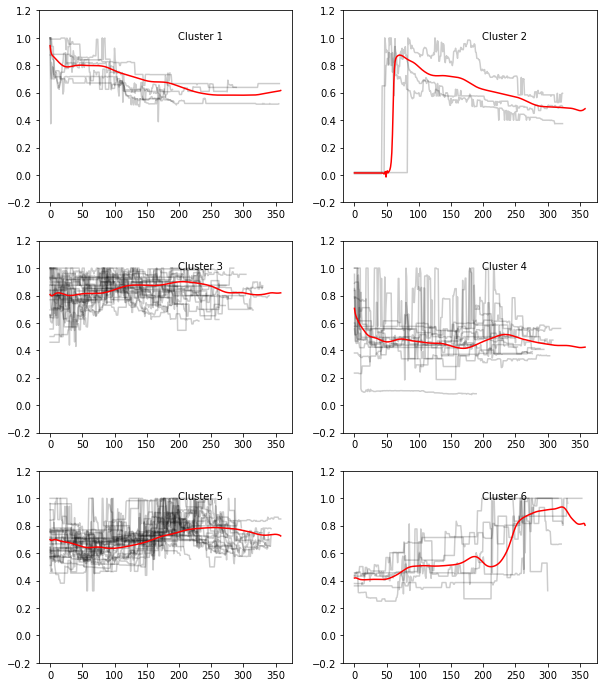

In [12]:
plot_cluster(kms1, X1, y_pred1, 'new_6m_softdtw_6')
show_labels(kms1, y_pred1, labels1['label'])

Try euclidean distance with equal length data.

In [13]:
new_eqts = load_time_series_txt('../data/amazon/NEW_eqts_1y.txt')
labels_eq = pd.read_csv('../data/amazon/NEW_label_1y.txt', header=None, names=['label'])
X2 = TimeSeriesScalerZeroMax().fit_transform(new_eqts)

Cluster again and show the result.

In [14]:
t = time.time()
kme = TimeSeriesKMeans(n_clusters=6, metric='euclidean', random_state=501, max_iter=20, n_jobs=-1)
y_pred2 = kme.fit_predict(X2)
print(f'Finish training, time elapsed: {time.time() - t:.2f}s.')

Finish training, time elapsed: 0.07s.


Cluster 1: 
	1 cpu:  cpu AMD ryzen 9 3900XT
	14 gpu:  gpu MSI NVIDIA Geforce RTX 2060 Super, gpu MSI NVIDIA Geforce RTX 2070, gpu MSI NVIDIA Geforce RTX 2070 Super, gpu MSI NVIDIA Geforce RTX 2080 Super, gpu MSI NVIDIA Geforce RTX 2080 Super, gpu MSI AMD Radeon RX 5500 XT, gpu EVGA NVIDIA Geforce RTX 2060, gpu Sapphire Technology AMD Radeon RX 5500 XT, gpu Sapphire Technology AMD Radeon RX 5600 XT, gpu Sapphire Technology AMD Radeon RX 5700 XT, gpu Gigabyte NVIDIA Geforce RTX 2080 Super, gpu Gigabyte AMD Radeon RX 5700 XT, gpu ZOTAC NVIDIA Geforce RTX 2060 Super, gpu ZOTAC NVIDIA Geforce RTX 2080
	1 drive:  drive Kingston kc600 sata 2tb
Cluster 2: 
	14 cpu:  cpu Intel core i9-10940X, cpu Intel core i9-10920X, cpu Intel core i9-10900X, cpu Intel core i9-10900, cpu Intel core i9-10850K, cpu Intel core i9-9900KS, cpu Intel core i9-9900K, cpu Intel core i7-10700K, cpu Intel core i7-10700, cpu Intel core i5-10600K, cpu Intel core i5-10600, cpu Intel core i5-10500, cpu Intel core i5-10400, c

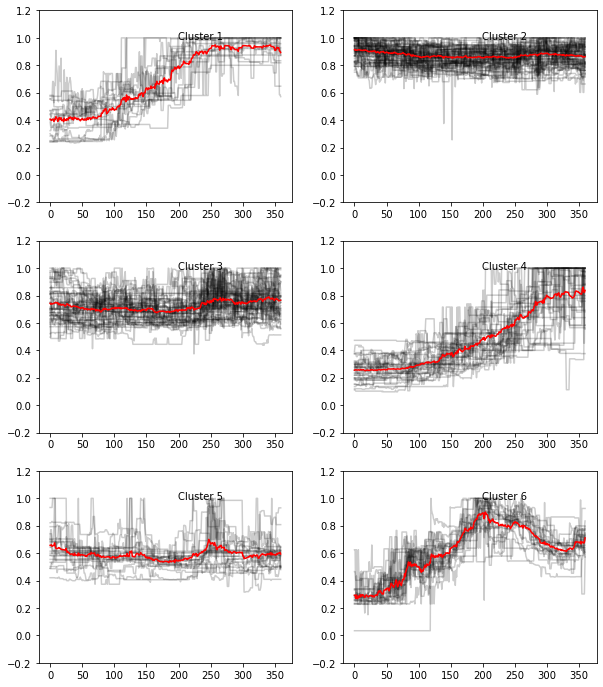

In [15]:
plot_cluster(kme, X2, y_pred2, 'new_1y_euclidean_6')
show_labels(kme, y_pred2, labels_eq['label'])

The euclidean distance gives us good clusters, and also it runs extremely fast.
Try KernelKMeans with equal length data.

In [16]:
from tslearn.clustering import KernelKMeans

t = time.time()
knkm = KernelKMeans(n_clusters=8, random_state=501, max_iter=20, n_jobs=-1)
y_pred3 = knkm.fit_predict(X2)
print(f'Finish training, time elapsed: {time.time() - t:.2f}s.')

Finish training, time elapsed: 14.36s.


Cluster 1: 
	5 cpu:  cpu Intel core i9-10900KF, cpu Intel core i7-10700, cpu Intel core i5-10600, cpu Intel core i5-10400F, cpu AMD ryzen 3 3100
	8 gpu:  gpu MSI NVIDIA Geforce RTX 2080 Super, gpu EVGA NVIDIA Geforce GTX 1660 Super, gpu EVGA NVIDIA Geforce GTX 1660 Ti, gpu ASUS AMD Radeon RX 5700 XT, gpu Sapphire Technology AMD Radeon RX 5500 XT, gpu Gigabyte AMD Radeon RX 5500 XT, gpu Gigabyte AMD Radeon RX 5700 XT, gpu ZOTAC NVIDIA Geforce RTX 2080
	8 drive:  drive Kingston kc600 sata 1tb, drive SAMSUNG 870 qvo sata 4tb, drive Seagate firecuda 120 sata 1tb, drive Seagate firecuda 120 sata 4tb, drive Seagate barracuda 120 sata 256gb, drive Western Digital wd gold sata 8tb, drive Western Digital wd red sata 2tb, drive Western Digital sn550 nvme 256gb
Cluster 2: 
	3 cpu:  cpu Intel core i3-10300, cpu Intel core i3-10100, cpu AMD ryzen threadripper 3990X
	6 gpu:  gpu MSI NVIDIA Geforce RTX 2060 Super, gpu MSI NVIDIA Geforce RTX 2070, gpu MSI NVIDIA Geforce RTX 2070, gpu MSI AMD Radeon RX

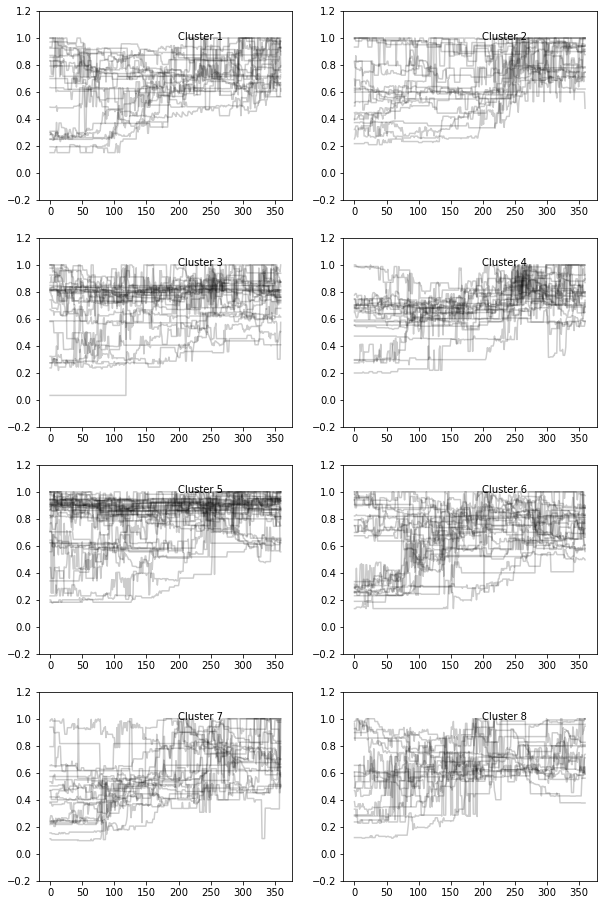

In [17]:
plot_cluster(knkm, X2, y_pred3, 'new_1y_kernel_8', show_center=False)
show_labels(knkm, y_pred3, labels_eq['label'])

KernelKMeans doesn't have a good clustering result. So, we try KShape with equal length data.

In [18]:
from tslearn.clustering import KShape

t = time.time()
ksp = KShape(n_clusters=4, random_state=501, max_iter=20)
y_pred4 = ksp.fit_predict(X2)
print(f'Finish training, time elapsed: {time.time() - t:.2f}s.')

Finish training, time elapsed: 1.20s.


Cluster 1: 
	17 cpu:  cpu Intel core i9-10940X, cpu Intel core i9-10900K, cpu Intel core i9-10900KF, cpu Intel core i9-10900, cpu Intel core i9-10900F, cpu Intel core i9-10850K, cpu Intel core i9-9900K, cpu Intel core i7-10700K, cpu Intel core i7-10700KF, cpu Intel core i7-10700, cpu Intel core i7-10700F, cpu Intel core i5-10600K, cpu Intel core i5-10600, cpu Intel core i5-10500, cpu Intel core i5-10400F, cpu Intel core i3-10300, cpu AMD ryzen 5 5600X
	16 drive:  drive ADATA su740 sata 2tb, drive ADATA su650 m2 256gb, drive Crucial bx500 sata 2tb, drive Crucial p5 nvme 512gb, drive Crucial p5 nvme 1tb, drive Crucial p5 nvme 2tb, drive Kingston kc2500 nvme 256gb, drive Kingston kc2500 nvme 512gb, drive Kingston kc2500 nvme 1tb, drive Kingston kc2500 nvme 2tb, drive Seagate firecuda 120 sata 4tb, drive Seagate barracuda 510 nvme 256gb, drive Western Digital wd red sata 2tb, drive Western Digital wd red plus 35 14tb, drive WD_BLACK wd black 35 8tb, drive Western Digital wd gold 35 18tb
Cl

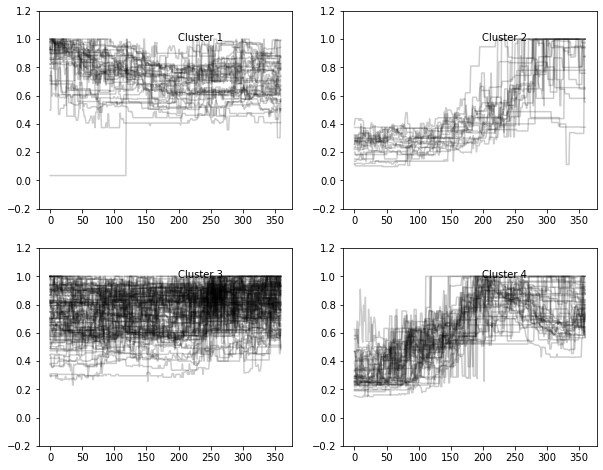

In [19]:
plot_cluster(ksp, X2, y_pred4, 'new_1y_kshape_4', show_center=False)
show_labels(ksp, y_pred4, labels_eq['label'])

KShape model runs pretty fast and has a good clustering result, but it only has 4 clusters.